In [1]:
#import *
import numpy as np
import os
import nglview as ngl
from ase.io import read, write
from molmass import Formula
import random

SYSDIR='/home/harish/GroPolBul'
##Give short polymer name and charge
res=input("Polymer abbrevation? (3 or 4 letters and preferable in caps): ") or "PE"
end=input("End group? (3 or 4 letters and preferable in caps): ") or "OH"
chg=input("Charge of the molecule: ") or "0"
print(res,end,chg)
MONDIR=str(SYSDIR)+'/monomers/'+str(res)+'_'+str(end)
os.popen('mkdir '+str(MONDIR)).read()
os.chdir(str(MONDIR))

##Paramaterize the monomer with acpype
mono=input("Monomer mol2 file or SMILE fomat: ") or "OCCCCCCCCCCCCO"
#os.popen('rm -r '+str(res)+'.acpype')
#os.popen('acpype -i '+str(mono)+' -b '+str(res)+' -n '+str(chg)+' -o gmx').read()
os.popen("sed -e 's/UNL/"+str(res)+"/g' "+str(res)+".acpype/sqm.pdb > "+str(res)+".pdb").read()
os.popen("sed -e 's/UNL/"+str(res)+"/g' "+str(res)+".acpype/ANTECHAMBER_AC.AC > "+str(res)+".ac").read()

#Visualize the molecule
mol=read(str(res)+'.acpype/PE_GMX.gro')
vi=ngl.show_ase(mol);vi.add_label(radius=2,color='black',label_type='atomindex')
vi


mkdir: cannot create directory ‘/home/harish/GroPolBul/monomers/PE_OH’: File exists


PE OH 0


NGLWidget()

In [4]:
#Defining CHAIN HEAD and TAIL in the monomer directory
os.chdir(str(MONDIR))
ac=open(str(res)+'.ac',mode='r') #Reading .ac file
[next(ac) for _ in range(2)] #Skipping first two lines of text
l=ac.readlines() #Reading lines

#Breaking the parts of monomer to CHAIN, HEAD and TAIL
chain=open(str(res)+'.chain','w+');head=open(str(res)+'.head','w+');tail=open(str(res)+'.tail','w+')
#Atom index where head and tail of monomer
#Check from above ngl view of mol
head_id=int(input("Monomer's Head atom index: ") or 2)
tail_id=int(input("Monomer's Tail atom index: ") or 11)

chain.write('HEAD_NAME '+str(l[head_id].split()[2])+'\n')
tail.write('HEAD_NAME '+str(l[head_id].split()[2])+'\n')
chain.write('TAIL_NAME '+str(l[tail_id].split()[2])+'\n')
head.write('TAIL_NAME '+str(l[tail_id].split()[2])+'\n')

head_omit=input("Atom indices to omit near head: ").split() or [0, 1, 14, 15, 16]
tail_omit=input("Atom indices to omit near tail: ").split() or [12, 13, 37, 38, 39]

for i in range(len(head_omit)):
	chain.write('OMIT_NAME '+str(l[int(head_omit[i])].split()[2])+'\n')
	tail.write('OMIT_NAME '+str(l[int(head_omit[i])].split()[2])+'\n')
chain.write('PRE_HEAD_TYPE '+str(l[tail_id].split()[9])+'\n')
tail.write('PRE_HEAD_TYPE '+str(l[tail_id].split()[9])+'\n')
tail.write('CHARGE '+str(chg))

for i in range(len(tail_omit)):
	chain.write('OMIT_NAME '+str(l[int(tail_omit[i])].split()[2])+'\n')
	head.write('OMIT_NAME '+str(l[int(tail_omit[i])].split()[2])+'\n')
chain.write('POST_TAIL_TYPE '+str(l[head_id].split()[9])+'\n')
chain.write('CHARGE '+str(float(chg)))
head.write('POST_TAIL_TYPE '+str(l[head_id].split()[9])+'\n')
head.write('CHARGE '+str(float(chg)))

chain.close();head.close();tail.close()

#Use prepgen to prepare the CHAIN, HEAD and TAIL res files
#Adds dummy atoms at the desired positions
os.popen('prepgen -i '+str(res)+'.ac -o '+str(res)+'.prepi -f prepi -m '+str(res)+'.chain -rn '+str(res)+' -rf '+str(res)+'.res').read() 
os.popen('prepgen -i '+str(res)+'.ac -o HPT.prepi -f prepi -m '+str(res)+'.head -rn HPT -rf HPT.res').read() 
os.popen('prepgen -i '+str(res)+'.ac -o TPT.prepi -f prepi -m '+str(res)+'.tail -rn TPT -rf TPT.res').read() 


'\nPRE_HEAD_TYPE is    c3\nNet charge of truncated molecule is     0.00\nHEAD_ATOM      3   C1\nMAIN_CHAIN     1    3   C1\nOMIT_ATOM      1    1    O\nOMIT_ATOM      2    2    C\nOMIT_ATOM      3   15    H\nOMIT_ATOM      4   16   H1\nOMIT_ATOM      5   17   H2\nNumber of mainchain atoms (including head and tail atom):     1\nNumber of omited atoms:     5'

In [5]:
#Build the desired homopolymer using above prepi files
n_mono_repeat=int(input("Number of monomers in the repeating unit: ") or 5)
n_mono_pol=int(input("Desired number of monomers in the polymer: ") or 20)
POLDIR=str(SYSDIR)+'/polymers/'+str(res)+'_'+str(end)+'_'+str(n_mono_pol)+'mer'
os.popen('mkdir '+str(POLDIR)).read()
os.chdir(str(POLDIR))
os.popen('cp '+str(MONDIR)+'/'+str(res)+'.pdb '+str(res)+'_repeatunit.pdb')

repeat=" ".join([res] * int(int(n_mono_pol/n_mono_repeat)-2))
print('HPT '+str(repeat)+' TPT')
tleap=open(str(res)+'_tleap.in','w+')
tleap.write('''source leaprc.gaff
loadamberprep '''+str(MONDIR)+'''/'''+str(res)+'''.prepi
loadamberprep '''+str(MONDIR)+'''/HPT.prepi
loadamberprep '''+str(MONDIR)+'''/TPT.prepi
mol = sequence {HPT '''+str(repeat)+''' TPT}
savepdb mol '''+str(res)+'''_polymer.pdb
saveamberparm mol '''+str(res)+'''_polymer.prmtop '''+str(res)+'''_polymer.inpcrd
quit''')
tleap.close()

os.popen('tleap -s -f '+str(res)+'_tleap.in > '+str(res)+'_tleap.out').read()
os.popen('acpype -p '+str(res)+'_polymer.prmtop -x '+str(res)+'_polymer.inpcrd').read()


mkdir: cannot create directory ‘/home/harish/GroPolBul/polymers/PE_OH_20mer’: File exists


HPT PE PE TPT


'==========================================================================\n| ACPYPE: AnteChamber PYthon Parser interfacE v. 2022.6.6 (c) 2023 AWSdS |\n==========================================================================\nConverting Amber input files to Gromacs ...\n==> Writing GROMACS files\n\n==> Disambiguating lower and uppercase atomtypes in GMX top file, even if identical.\n\n==> Writing GMX dihedrals for GMX 4.5 and higher.\n\nTotal time of execution: less than a second\n'

In [64]:
#Visualize the molecule
mol=read(str(res)+'_polymer.pdb')
vi=ngl.show_ase(mol);#vi.add_label(radius=2,color='black',label_type='atomindex')
vi


NGLWidget()

In [11]:
import parmed as pmd
from rdkit import Chem
from rdkit.Chem import AllChem

monomer_smiles = "CC(=O)OC(C)C"
n_units = 5

# Create the monomer molecule
monomer = Chem.MolFromSmiles(monomer_smiles)

# Generate a 3D structure for the monomer
AllChem.EmbedMolecule(monomer)

# Create a ParmEd structure from the monomer
pmd_monomer = pmd.load_rdkit(monomer)

# Assign force field parameters to the monomer
#ff = pmd.amber.AmberParameterSet()   #AmberParameterSet()
#ff.assign(pmd_monomer)

# Create the polymer by repeating the monomer
polymer = pmd_monomer * n_units
parmed.a
# Connect the monomers with appropriate bonds
for i in range(n_units - 1):
    last_atom = pmd_monomer.atoms[-1]
    first_atom = polymer.atoms[i * len(pmd_monomer.atoms)]
    bond_type = pmd.Bond  #BondType("single")
    polymer.add_bond((last_atom, first_atom, bond_type))

# Save the polymer as a PDB file and an AMBER topology and coordinate file
polymer.save("polymer.pdb", overwrite=True)
polymer.save("polymer.top", parameters=ff, overwrite=True)
polymer.save("polymer.crd", format="rst7", overwrite=True)

print("Polymer structure and force field parameters saved.")


[16:28:39] Molecule does not have explicit Hs. Consider calling AddHs()


AttributeError: 'Structure' object has no attribute 'add_bond'

In [16]:
import mdtraj as md
from rdkit import Chem
from rdkit.Chem import AllChem
#from simtk.openmm.app import *
#from simtk.openmm import *
from simtk.unit import *

monomer_smiles = "CC(=O)OC(C)C"
n_units = 5

# Create the monomer molecule
monomer = Chem.MolFromSmiles(monomer_smiles)

# Generate a 3D structure for the monomer
AllChem.EmbedMolecule(monomer)

# Create a topology for the monomer
monomer_top = md.Topology.from_openmm(
    app.Topology().from_molecules(monomer)
)

# Create a system for the monomer
ff = app.ForceField('amber14-all.xml', 'amber14/tip3pfb.xml')
monomer_system = ff.createSystem(monomer_top)

# Assign force field parameters to the monomer
for i in range(monomer_top.n_atoms):
    atom_idx = monomer_top.atom(i).index
    force = monomer_system.getForce(0)
    params = ff.getParticleParameters(i)
    force.setParticleParameters(atom_idx, *params)

# Create the polymer by repeating the monomer
polymer = md.Trajectory(
    xyz=monomer_top.xyz[0].repeat(n_units, axis=0),
    topology=monomer_top * n_units,
)

# Connect the monomers with appropriate bonds
bond_force = monomer_system.getForce(1)
for i in range(n_units - 1):
    last_atom = monomer_top.atom(-1).index + i * monomer_top.n_atoms
    first_atom = monomer_top.atom(0).index + (i + 1) * monomer_top.n_atoms
    bond_force.addBond(last_atom, first_atom)

# Save the polymer as a LAMMPS data file
md.formats.LAMMPSData.write_structure(
    polymer.topology,
    polymer.unitcell_vectors,
    polymer.xyz[0],
    "polymer.data",
    atom_style='full',
    bonds='all',
    forcefield='amber',
    masses=ff._masses,
    pair_coeffs=ff._lj_params,
    bond_coeffs=ff._bond_params,
    angle_coeffs=ff._angle_params,
    dihedral_coeffs=ff._dihedral_params,
    improper_coeffs=ff._improper_params,
)

print("Polymer structure and force field parameters saved.")


ModuleNotFoundError: No module named 'simtk.unit'

In [23]:
from rdkit import Chem
from rdkit.Chem.Draw import IPythonConsole
from rdkit.Chem import Draw
IPythonConsole.drawOptions.addAtomIndices = True
IPythonConsole.molSize = 500,500
def mol_with_atom_index(mol):
    for atom in mol.GetAtoms():
        atom.SetAtomMapNum(atom.GetIdx())
    return mol

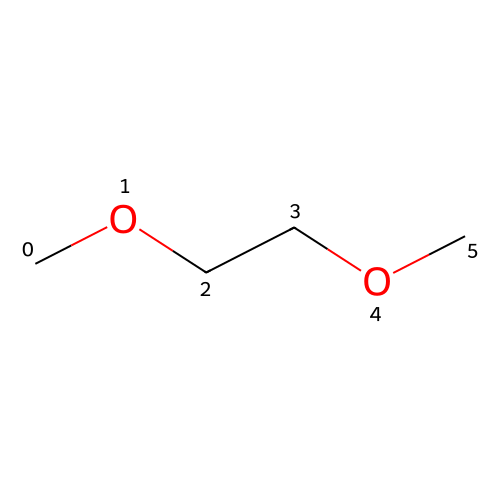

In [27]:
# Test in a kinase inhibitor
mol = Chem.MolFromSmiles("COCCOC")
# Default
mol


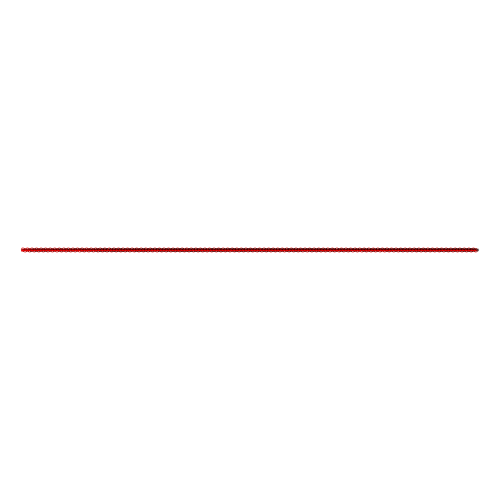

In [29]:
# Test in a kinase inhibitor
strg="COCCOC"
mol = Chem.MolFromSmiles(strg*100)
# Default
mol


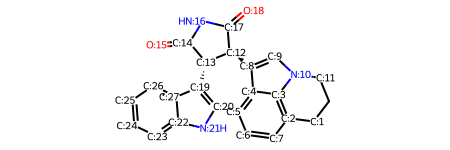

In [20]:
mol_with_atom_index(mol)